<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:14:08] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


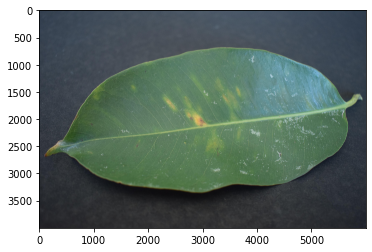

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

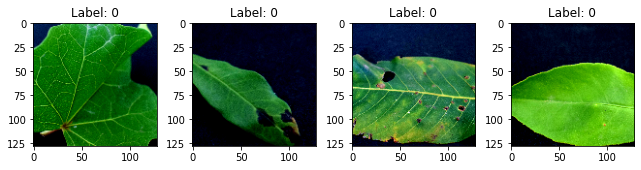

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:14:14] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:14:16] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2621944416462079 samples/sec                   batch loss = 0.4547898769378662 | accuracy = 0.85


Epoch[1] Batch[10] Speed: 1.2356944267267755 samples/sec                   batch loss = 0.788968563079834 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.266734237036697 samples/sec                   batch loss = 0.8932629823684692 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.268017720124876 samples/sec                   batch loss = 0.7384167313575745 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.2568889204536728 samples/sec                   batch loss = 0.8926884531974792 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.2581118561549052 samples/sec                   batch loss = 0.7186552286148071 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2428953926267627 samples/sec                   batch loss = 2.2738258838653564 | accuracy = 0.55


Epoch[1] Batch[40] Speed: 1.2484542234260039 samples/sec                   batch loss = 0.6384300589561462 | accuracy = 0.5875


Epoch[1] Batch[45] Speed: 1.2521100024591103 samples/sec                   batch loss = 1.0313079357147217 | accuracy = 0.5722222222222222


Epoch[1] Batch[50] Speed: 1.2597761296183845 samples/sec                   batch loss = 0.5416758060455322 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.2587328578915127 samples/sec                   batch loss = 0.6302288770675659 | accuracy = 0.5681818181818182


Epoch[1] Batch[60] Speed: 1.2663448047131545 samples/sec                   batch loss = 0.42905494570732117 | accuracy = 0.575


Epoch[1] Batch[65] Speed: 1.2705892331880269 samples/sec                   batch loss = 0.4842776954174042 | accuracy = 0.573076923076923


Epoch[1] Batch[70] Speed: 1.2602188938309484 samples/sec                   batch loss = 0.4272800087928772 | accuracy = 0.5892857142857143


Epoch[1] Batch[75] Speed: 1.2561515969848558 samples/sec                   batch loss = 0.8178872466087341 | accuracy = 0.5833333333333334


Epoch[1] Batch[80] Speed: 1.2532964064987704 samples/sec                   batch loss = 0.5792865753173828 | accuracy = 0.5875


Epoch[1] Batch[85] Speed: 1.261251356934726 samples/sec                   batch loss = 0.9561240673065186 | accuracy = 0.5941176470588235


Epoch[1] Batch[90] Speed: 1.266236422021347 samples/sec                   batch loss = 0.7177374362945557 | accuracy = 0.6


Epoch[1] Batch[95] Speed: 1.2627899206621067 samples/sec                   batch loss = 0.5463541746139526 | accuracy = 0.6026315789473684


Epoch[1] Batch[100] Speed: 1.2671305123848196 samples/sec                   batch loss = 0.49754104018211365 | accuracy = 0.605


Epoch[1] Batch[105] Speed: 1.2670593138044928 samples/sec                   batch loss = 1.389201045036316 | accuracy = 0.6023809523809524


Epoch[1] Batch[110] Speed: 1.2701711745036917 samples/sec                   batch loss = 0.33193814754486084 | accuracy = 0.6068181818181818


Epoch[1] Batch[115] Speed: 1.2588887945107543 samples/sec                   batch loss = 0.7212015986442566 | accuracy = 0.6086956521739131


Epoch[1] Batch[120] Speed: 1.2617174568399216 samples/sec                   batch loss = 0.3296374976634979 | accuracy = 0.6145833333333334


Epoch[1] Batch[125] Speed: 1.2608341132813716 samples/sec                   batch loss = 0.4598097503185272 | accuracy = 0.618


Epoch[1] Batch[130] Speed: 1.252845394282403 samples/sec                   batch loss = 0.8598857522010803 | accuracy = 0.6153846153846154


Epoch[1] Batch[135] Speed: 1.2622198909661293 samples/sec                   batch loss = 0.6505274176597595 | accuracy = 0.6092592592592593


Epoch[1] Batch[140] Speed: 1.2628093107221343 samples/sec                   batch loss = 0.5802115797996521 | accuracy = 0.6142857142857143


Epoch[1] Batch[145] Speed: 1.2686333847953635 samples/sec                   batch loss = 0.3916180729866028 | accuracy = 0.6206896551724138


Epoch[1] Batch[150] Speed: 1.2607627678109474 samples/sec                   batch loss = 0.42396438121795654 | accuracy = 0.6216666666666667


Epoch[1] Batch[155] Speed: 1.2650439095106747 samples/sec                   batch loss = 1.113979458808899 | accuracy = 0.6274193548387097


Epoch[1] Batch[160] Speed: 1.2527632568528113 samples/sec                   batch loss = 0.5917100310325623 | accuracy = 0.6296875


Epoch[1] Batch[165] Speed: 1.2550151711479938 samples/sec                   batch loss = 0.49092262983322144 | accuracy = 0.6303030303030303


Epoch[1] Batch[170] Speed: 1.2522956155886367 samples/sec                   batch loss = 0.5593951344490051 | accuracy = 0.6308823529411764


Epoch[1] Batch[175] Speed: 1.2577542961348374 samples/sec                   batch loss = 0.6300747394561768 | accuracy = 0.6271428571428571


Epoch[1] Batch[180] Speed: 1.2609356026224297 samples/sec                   batch loss = 0.14016786217689514 | accuracy = 0.6333333333333333


Epoch[1] Batch[185] Speed: 1.2668278780094515 samples/sec                   batch loss = 1.0039201974868774 | accuracy = 0.6378378378378379


Epoch[1] Batch[190] Speed: 1.2653519906429869 samples/sec                   batch loss = 0.38779911398887634 | accuracy = 0.6394736842105263


Epoch[1] Batch[195] Speed: 1.2694564182994588 samples/sec                   batch loss = 0.6094996333122253 | accuracy = 0.6423076923076924


Epoch[1] Batch[200] Speed: 1.2622419225494355 samples/sec                   batch loss = 0.4691002368927002 | accuracy = 0.64


Epoch[1] Batch[205] Speed: 1.2632350915971062 samples/sec                   batch loss = 0.47208449244499207 | accuracy = 0.6426829268292683


Epoch[1] Batch[210] Speed: 1.2712336937982447 samples/sec                   batch loss = 0.46108996868133545 | accuracy = 0.6428571428571429


Epoch[1] Batch[215] Speed: 1.2619697155237803 samples/sec                   batch loss = 0.7286384701728821 | accuracy = 0.6430232558139535


Epoch[1] Batch[220] Speed: 1.2616504705428675 samples/sec                   batch loss = 0.5792095065116882 | accuracy = 0.6431818181818182


Epoch[1] Batch[225] Speed: 1.2598883289373857 samples/sec                   batch loss = 0.7654752731323242 | accuracy = 0.6444444444444445


Epoch[1] Batch[230] Speed: 1.2674266848013798 samples/sec                   batch loss = 0.5991927981376648 | accuracy = 0.6456521739130435


Epoch[1] Batch[235] Speed: 1.2635634183631201 samples/sec                   batch loss = 1.222914457321167 | accuracy = 0.6478723404255319


Epoch[1] Batch[240] Speed: 1.2639612353044833 samples/sec                   batch loss = 1.1388951539993286 | accuracy = 0.6510416666666666


Epoch[1] Batch[245] Speed: 1.268014845037687 samples/sec                   batch loss = 0.2950117290019989 | accuracy = 0.6540816326530612


Epoch[1] Batch[250] Speed: 1.2722705911883296 samples/sec                   batch loss = 0.6195665001869202 | accuracy = 0.655


Epoch[1] Batch[255] Speed: 1.264493667890369 samples/sec                   batch loss = 0.5440239310264587 | accuracy = 0.6588235294117647


Epoch[1] Batch[260] Speed: 1.2572107530788041 samples/sec                   batch loss = 0.30234038829803467 | accuracy = 0.6615384615384615


Epoch[1] Batch[265] Speed: 1.2615412772540577 samples/sec                   batch loss = 1.5690666437149048 | accuracy = 0.6613207547169812


Epoch[1] Batch[270] Speed: 1.2599697001352776 samples/sec                   batch loss = 0.744566798210144 | accuracy = 0.6592592592592592


Epoch[1] Batch[275] Speed: 1.2617005672728847 samples/sec                   batch loss = 0.6489702463150024 | accuracy = 0.6618181818181819


Epoch[1] Batch[280] Speed: 1.2615227798289488 samples/sec                   batch loss = 0.353213369846344 | accuracy = 0.6642857142857143


Epoch[1] Batch[285] Speed: 1.2636703921251986 samples/sec                   batch loss = 0.7972770929336548 | accuracy = 0.6631578947368421


Epoch[1] Batch[290] Speed: 1.2620167997946738 samples/sec                   batch loss = 1.079078197479248 | accuracy = 0.6637931034482759


Epoch[1] Batch[295] Speed: 1.2636273720293427 samples/sec                   batch loss = 0.916300356388092 | accuracy = 0.6610169491525424


Epoch[1] Batch[300] Speed: 1.2661627438541296 samples/sec                   batch loss = 0.5369423627853394 | accuracy = 0.6616666666666666


Epoch[1] Batch[305] Speed: 1.2663379227207927 samples/sec                   batch loss = 0.48086678981781006 | accuracy = 0.6622950819672131


Epoch[1] Batch[310] Speed: 1.263191530483995 samples/sec                   batch loss = 0.5465459823608398 | accuracy = 0.6620967741935484


Epoch[1] Batch[315] Speed: 1.2590343765165983 samples/sec                   batch loss = 0.6891292929649353 | accuracy = 0.6603174603174603


Epoch[1] Batch[320] Speed: 1.261207079237019 samples/sec                   batch loss = 1.1228958368301392 | accuracy = 0.6640625


Epoch[1] Batch[325] Speed: 1.2695764972232297 samples/sec                   batch loss = 0.5294666290283203 | accuracy = 0.6623076923076923


Epoch[1] Batch[330] Speed: 1.2688421618335648 samples/sec                   batch loss = 0.5390185713768005 | accuracy = 0.6636363636363637


Epoch[1] Batch[335] Speed: 1.272526508668193 samples/sec                   batch loss = 0.687563419342041 | accuracy = 0.6634328358208955


Epoch[1] Batch[340] Speed: 1.2663319010388363 samples/sec                   batch loss = 0.5989253520965576 | accuracy = 0.6639705882352941


Epoch[1] Batch[345] Speed: 1.2646012758311103 samples/sec                   batch loss = 0.3068971037864685 | accuracy = 0.6666666666666666


Epoch[1] Batch[350] Speed: 1.2713113350377896 samples/sec                   batch loss = 0.6965106725692749 | accuracy = 0.6664285714285715


Epoch[1] Batch[355] Speed: 1.2625838905340239 samples/sec                   batch loss = 0.24151839315891266 | accuracy = 0.6676056338028169


Epoch[1] Batch[360] Speed: 1.268884865969002 samples/sec                   batch loss = 0.4338143467903137 | accuracy = 0.6694444444444444


Epoch[1] Batch[365] Speed: 1.2604729210672523 samples/sec                   batch loss = 0.6259300708770752 | accuracy = 0.6698630136986301


Epoch[1] Batch[370] Speed: 1.2656296688682571 samples/sec                   batch loss = 0.20403450727462769 | accuracy = 0.672972972972973


Epoch[1] Batch[375] Speed: 1.2618264908250068 samples/sec                   batch loss = 1.019438624382019 | accuracy = 0.6726666666666666


Epoch[1] Batch[380] Speed: 1.2658628637799851 samples/sec                   batch loss = 0.41650253534317017 | accuracy = 0.6736842105263158


Epoch[1] Batch[385] Speed: 1.2690820140027634 samples/sec                   batch loss = 0.32211580872535706 | accuracy = 0.6746753246753247


Epoch[1] Batch[390] Speed: 1.2625363839006372 samples/sec                   batch loss = 0.48374828696250916 | accuracy = 0.6724358974358975


Epoch[1] Batch[395] Speed: 1.2681246826327734 samples/sec                   batch loss = 0.29032638669013977 | accuracy = 0.6734177215189874


Epoch[1] Batch[400] Speed: 1.2606730526319903 samples/sec                   batch loss = 0.6949533820152283 | accuracy = 0.671875


Epoch[1] Batch[405] Speed: 1.2586230359634318 samples/sec                   batch loss = 0.45731693506240845 | accuracy = 0.674074074074074


Epoch[1] Batch[410] Speed: 1.2608105200609228 samples/sec                   batch loss = 0.19378364086151123 | accuracy = 0.675


Epoch[1] Batch[415] Speed: 1.2624784306489727 samples/sec                   batch loss = 0.4512200355529785 | accuracy = 0.6728915662650602


Epoch[1] Batch[420] Speed: 1.2590063155872535 samples/sec                   batch loss = 0.6190590858459473 | accuracy = 0.6714285714285714


Epoch[1] Batch[425] Speed: 1.2589856249961073 samples/sec                   batch loss = 0.7371342182159424 | accuracy = 0.6717647058823529


Epoch[1] Batch[430] Speed: 1.2735583629432916 samples/sec                   batch loss = 0.27783137559890747 | accuracy = 0.6732558139534883


Epoch[1] Batch[435] Speed: 1.2698293135834793 samples/sec                   batch loss = 0.7072884440422058 | accuracy = 0.6724137931034483


Epoch[1] Batch[440] Speed: 1.2692565612842468 samples/sec                   batch loss = 0.653641939163208 | accuracy = 0.6727272727272727


Epoch[1] Batch[445] Speed: 1.261868913837959 samples/sec                   batch loss = 0.2455761730670929 | accuracy = 0.6741573033707865


Epoch[1] Batch[450] Speed: 1.2584377136108071 samples/sec                   batch loss = 0.4796871840953827 | accuracy = 0.675


Epoch[1] Batch[455] Speed: 1.2584566870543477 samples/sec                   batch loss = 0.7992686629295349 | accuracy = 0.6736263736263737


Epoch[1] Batch[460] Speed: 1.2614581853837699 samples/sec                   batch loss = 0.48494255542755127 | accuracy = 0.675


Epoch[1] Batch[465] Speed: 1.2648455346973868 samples/sec                   batch loss = 0.34979936480522156 | accuracy = 0.6747311827956989


Epoch[1] Batch[470] Speed: 1.2696116606317314 samples/sec                   batch loss = 0.3098868727684021 | accuracy = 0.675531914893617


Epoch[1] Batch[475] Speed: 1.2703215900705245 samples/sec                   batch loss = 0.7159904837608337 | accuracy = 0.6757894736842105


Epoch[1] Batch[480] Speed: 1.2692514720426697 samples/sec                   batch loss = 0.23916536569595337 | accuracy = 0.6760416666666667


Epoch[1] Batch[485] Speed: 1.267270157565646 samples/sec                   batch loss = 0.7241657376289368 | accuracy = 0.6757731958762887


Epoch[1] Batch[490] Speed: 1.2681539183576995 samples/sec                   batch loss = 0.9667143821716309 | accuracy = 0.6760204081632653


Epoch[1] Batch[495] Speed: 1.2634211637075892 samples/sec                   batch loss = 0.3074924945831299 | accuracy = 0.6772727272727272


Epoch[1] Batch[500] Speed: 1.2566727625659104 samples/sec                   batch loss = 0.7944027185440063 | accuracy = 0.677


Epoch[1] Batch[505] Speed: 1.2566500778308567 samples/sec                   batch loss = 0.4087287485599518 | accuracy = 0.6782178217821783


Epoch[1] Batch[510] Speed: 1.255220710478545 samples/sec                   batch loss = 0.8249533176422119 | accuracy = 0.678921568627451


Epoch[1] Batch[515] Speed: 1.2523359979374082 samples/sec                   batch loss = 0.35075342655181885 | accuracy = 0.679126213592233


Epoch[1] Batch[520] Speed: 1.2557983460981192 samples/sec                   batch loss = 0.4267598092556 | accuracy = 0.6793269230769231


Epoch[1] Batch[525] Speed: 1.2599628872597441 samples/sec                   batch loss = 0.3896244764328003 | accuracy = 0.6804761904761905


Epoch[1] Batch[530] Speed: 1.2560699658723513 samples/sec                   batch loss = 0.6105146408081055 | accuracy = 0.680188679245283


Epoch[1] Batch[535] Speed: 1.2596129748751852 samples/sec                   batch loss = 0.5166865587234497 | accuracy = 0.6813084112149532


Epoch[1] Batch[540] Speed: 1.2607708210122257 samples/sec                   batch loss = 0.7524886727333069 | accuracy = 0.6819444444444445


Epoch[1] Batch[545] Speed: 1.2581795051144335 samples/sec                   batch loss = 0.8222468495368958 | accuracy = 0.6821100917431193


Epoch[1] Batch[550] Speed: 1.2636071003004314 samples/sec                   batch loss = 0.20755642652511597 | accuracy = 0.6831818181818182


Epoch[1] Batch[555] Speed: 1.2588807653344252 samples/sec                   batch loss = 0.1719314455986023 | accuracy = 0.6842342342342342


Epoch[1] Batch[560] Speed: 1.2642682176391216 samples/sec                   batch loss = 0.4829618036746979 | accuracy = 0.6848214285714286


Epoch[1] Batch[565] Speed: 1.2693904325950025 samples/sec                   batch loss = 0.18198177218437195 | accuracy = 0.6858407079646017


Epoch[1] Batch[570] Speed: 1.2663839952621228 samples/sec                   batch loss = 0.6939931511878967 | accuracy = 0.6850877192982456


Epoch[1] Batch[575] Speed: 1.263858496677866 samples/sec                   batch loss = 0.3797629773616791 | accuracy = 0.6860869565217391


Epoch[1] Batch[580] Speed: 1.265282804826701 samples/sec                   batch loss = 0.6369624733924866 | accuracy = 0.6857758620689656


Epoch[1] Batch[585] Speed: 1.2638469765202598 samples/sec                   batch loss = 0.5411121845245361 | accuracy = 0.6858974358974359


Epoch[1] Batch[590] Speed: 1.257093661151046 samples/sec                   batch loss = 0.6041707396507263 | accuracy = 0.6864406779661016


Epoch[1] Batch[595] Speed: 1.2547876446779125 samples/sec                   batch loss = 0.44084927439689636 | accuracy = 0.6873949579831933


Epoch[1] Batch[600] Speed: 1.2565051407676557 samples/sec                   batch loss = 0.15494653582572937 | accuracy = 0.68875


Epoch[1] Batch[605] Speed: 1.2616611916675333 samples/sec                   batch loss = 0.2982991337776184 | accuracy = 0.6896694214876034


Epoch[1] Batch[610] Speed: 1.2636902851510508 samples/sec                   batch loss = 0.6695522665977478 | accuracy = 0.6893442622950819


Epoch[1] Batch[615] Speed: 1.265470626140046 samples/sec                   batch loss = 1.084995985031128 | accuracy = 0.6902439024390243


Epoch[1] Batch[620] Speed: 1.2644536412660743 samples/sec                   batch loss = 0.1539677381515503 | accuracy = 0.6923387096774194


Epoch[1] Batch[625] Speed: 1.2638291730534028 samples/sec                   batch loss = 0.5957332849502563 | accuracy = 0.6932


Epoch[1] Batch[630] Speed: 1.2616330135262284 samples/sec                   batch loss = 0.16636408865451813 | accuracy = 0.694047619047619


Epoch[1] Batch[635] Speed: 1.252531496539737 samples/sec                   batch loss = 0.5655597448348999 | accuracy = 0.6948818897637795


Epoch[1] Batch[640] Speed: 1.2568994666430728 samples/sec                   batch loss = 0.6558274030685425 | accuracy = 0.69453125


Epoch[1] Batch[645] Speed: 1.2563715271251292 samples/sec                   batch loss = 0.44249895215034485 | accuracy = 0.6949612403100776


Epoch[1] Batch[650] Speed: 1.2544369424941866 samples/sec                   batch loss = 0.7771331667900085 | accuracy = 0.6961538461538461


Epoch[1] Batch[655] Speed: 1.2541032163666848 samples/sec                   batch loss = 0.662688672542572 | accuracy = 0.6961832061068702


Epoch[1] Batch[660] Speed: 1.2517678932719891 samples/sec                   batch loss = 0.48519444465637207 | accuracy = 0.6973484848484849


Epoch[1] Batch[665] Speed: 1.2572095283520441 samples/sec                   batch loss = 1.2176311016082764 | accuracy = 0.6969924812030075


Epoch[1] Batch[670] Speed: 1.2626528765303646 samples/sec                   batch loss = 0.2432146966457367 | accuracy = 0.698134328358209


Epoch[1] Batch[675] Speed: 1.2673271156015273 samples/sec                   batch loss = 0.44864073395729065 | accuracy = 0.6988888888888889


Epoch[1] Batch[680] Speed: 1.272203540846368 samples/sec                   batch loss = 0.6434042453765869 | accuracy = 0.6992647058823529


Epoch[1] Batch[685] Speed: 1.2649719914513513 samples/sec                   batch loss = 0.694368302822113 | accuracy = 0.698905109489051


Epoch[1] Batch[690] Speed: 1.261933265597842 samples/sec                   batch loss = 0.6264814138412476 | accuracy = 0.6996376811594203


Epoch[1] Batch[695] Speed: 1.2626529715575971 samples/sec                   batch loss = 0.22149020433425903 | accuracy = 0.7014388489208633


Epoch[1] Batch[700] Speed: 1.2640416096918503 samples/sec                   batch loss = 0.6293312311172485 | accuracy = 0.7014285714285714


Epoch[1] Batch[705] Speed: 1.2706128088875863 samples/sec                   batch loss = 0.438259482383728 | accuracy = 0.7021276595744681


Epoch[1] Batch[710] Speed: 1.2625414194343838 samples/sec                   batch loss = 0.5518162250518799 | accuracy = 0.701056338028169


Epoch[1] Batch[715] Speed: 1.2720403341608528 samples/sec                   batch loss = 0.4389509856700897 | accuracy = 0.7017482517482517


Epoch[1] Batch[720] Speed: 1.2660000324475773 samples/sec                   batch loss = 1.1109675168991089 | accuracy = 0.7017361111111111


Epoch[1] Batch[725] Speed: 1.2697092829258352 samples/sec                   batch loss = 1.0100462436676025 | accuracy = 0.7010344827586207


Epoch[1] Batch[730] Speed: 1.2595273000923106 samples/sec                   batch loss = 0.9931135773658752 | accuracy = 0.7023972602739726


Epoch[1] Batch[735] Speed: 1.2573402107316132 samples/sec                   batch loss = 0.6866207122802734 | accuracy = 0.7030612244897959


Epoch[1] Batch[740] Speed: 1.2573846885088196 samples/sec                   batch loss = 0.28700244426727295 | accuracy = 0.7023648648648648


Epoch[1] Batch[745] Speed: 1.256069589716668 samples/sec                   batch loss = 0.531317412853241 | accuracy = 0.7030201342281879


Epoch[1] Batch[750] Speed: 1.2574921266281343 samples/sec                   batch loss = 0.20398636162281036 | accuracy = 0.704


Epoch[1] Batch[755] Speed: 1.2526126683598906 samples/sec                   batch loss = 0.6453959345817566 | accuracy = 0.7036423841059603


Epoch[1] Batch[760] Speed: 1.2588574340738463 samples/sec                   batch loss = 0.42523786425590515 | accuracy = 0.7042763157894737


Epoch[1] Batch[765] Speed: 1.258143085105306 samples/sec                   batch loss = 0.7596478462219238 | accuracy = 0.7035947712418301


Epoch[1] Batch[770] Speed: 1.2668571496315197 samples/sec                   batch loss = 0.8356250524520874 | accuracy = 0.7038961038961039


Epoch[1] Batch[775] Speed: 1.2643070892072203 samples/sec                   batch loss = 0.5277255177497864 | accuracy = 0.7038709677419355


Epoch[1] Batch[780] Speed: 1.2565480537124873 samples/sec                   batch loss = 0.43262815475463867 | accuracy = 0.7035256410256411


Epoch[1] Batch[785] Speed: 1.261152471197842 samples/sec                   batch loss = 0.5665505528450012 | accuracy = 0.7035031847133758


[Epoch 1] training: accuracy=0.7046319796954315
[Epoch 1] time cost: 650.8117916584015
[Epoch 1] validation: validation accuracy=0.7122222222222222


Epoch[2] Batch[5] Speed: 1.266549004518284 samples/sec                   batch loss = 0.5511675477027893 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.273719445209967 samples/sec                   batch loss = 0.5846463441848755 | accuracy = 0.65


Epoch[2] Batch[15] Speed: 1.2716275850422685 samples/sec                   batch loss = 0.7851385474205017 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2688151973319906 samples/sec                   batch loss = 0.2776798605918884 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.264659138158369 samples/sec                   batch loss = 0.31975501775741577 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.2687845877743436 samples/sec                   batch loss = 0.6487032771110535 | accuracy = 0.725


Epoch[2] Batch[35] Speed: 1.2603133728066682 samples/sec                   batch loss = 0.2710973620414734 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.245799074361745 samples/sec                   batch loss = 0.2277832329273224 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.26351127046279 samples/sec                   batch loss = 0.7813588976860046 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.2592804592467728 samples/sec                   batch loss = 0.2101387232542038 | accuracy = 0.765


Epoch[2] Batch[55] Speed: 1.2631706069999846 samples/sec                   batch loss = 0.5086033940315247 | accuracy = 0.7681818181818182


Epoch[2] Batch[60] Speed: 1.2702509941855553 samples/sec                   batch loss = 0.4232672452926636 | accuracy = 0.7708333333333334


Epoch[2] Batch[65] Speed: 1.2664703186116577 samples/sec                   batch loss = 0.568325400352478 | accuracy = 0.7576923076923077


Epoch[2] Batch[70] Speed: 1.2704622281456353 samples/sec                   batch loss = 0.592390775680542 | accuracy = 0.7535714285714286


Epoch[2] Batch[75] Speed: 1.2682330053522568 samples/sec                   batch loss = 0.2119477540254593 | accuracy = 0.76


Epoch[2] Batch[80] Speed: 1.2660840103881394 samples/sec                   batch loss = 0.7811526656150818 | accuracy = 0.75


Epoch[2] Batch[85] Speed: 1.2640815149916464 samples/sec                   batch loss = 0.21511109173297882 | accuracy = 0.75


Epoch[2] Batch[90] Speed: 1.264479848888426 samples/sec                   batch loss = 0.22154060006141663 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.2696989050397476 samples/sec                   batch loss = 0.4215104877948761 | accuracy = 0.7552631578947369


Epoch[2] Batch[100] Speed: 1.2644648865855095 samples/sec                   batch loss = 0.39747124910354614 | accuracy = 0.755


Epoch[2] Batch[105] Speed: 1.2626605737825458 samples/sec                   batch loss = 0.5993366837501526 | accuracy = 0.7523809523809524


Epoch[2] Batch[110] Speed: 1.2603585345953334 samples/sec                   batch loss = 1.1074646711349487 | accuracy = 0.75


Epoch[2] Batch[115] Speed: 1.2751470823738058 samples/sec                   batch loss = 0.2749823331832886 | accuracy = 0.7434782608695653


Epoch[2] Batch[120] Speed: 1.277152928815684 samples/sec                   batch loss = 0.8760880827903748 | accuracy = 0.7458333333333333


Epoch[2] Batch[125] Speed: 1.2710234550316752 samples/sec                   batch loss = 0.38838934898376465 | accuracy = 0.746


Epoch[2] Batch[130] Speed: 1.2692550249051304 samples/sec                   batch loss = 0.37218615412712097 | accuracy = 0.75


Epoch[2] Batch[135] Speed: 1.271547399526918 samples/sec                   batch loss = 0.8759064674377441 | accuracy = 0.7462962962962963


Epoch[2] Batch[140] Speed: 1.267457037370728 samples/sec                   batch loss = 1.4311604499816895 | accuracy = 0.7446428571428572


Epoch[2] Batch[145] Speed: 1.2641085644079773 samples/sec                   batch loss = 0.732912540435791 | accuracy = 0.7362068965517241


Epoch[2] Batch[150] Speed: 1.2670775911712784 samples/sec                   batch loss = 0.9631081819534302 | accuracy = 0.7316666666666667


Epoch[2] Batch[155] Speed: 1.2763830036997665 samples/sec                   batch loss = 0.37726858258247375 | accuracy = 0.7338709677419355


Epoch[2] Batch[160] Speed: 1.2679705703413433 samples/sec                   batch loss = 0.4257189929485321 | accuracy = 0.7359375


Epoch[2] Batch[165] Speed: 1.272729617509354 samples/sec                   batch loss = 0.668578028678894 | accuracy = 0.7363636363636363


Epoch[2] Batch[170] Speed: 1.2729964411644887 samples/sec                   batch loss = 0.8822253942489624 | accuracy = 0.7338235294117647


Epoch[2] Batch[175] Speed: 1.2736548527090306 samples/sec                   batch loss = 0.3400968909263611 | accuracy = 0.7357142857142858


Epoch[2] Batch[180] Speed: 1.2695152061023116 samples/sec                   batch loss = 0.7315599322319031 | accuracy = 0.7333333333333333


Epoch[2] Batch[185] Speed: 1.267129842468416 samples/sec                   batch loss = 0.639946460723877 | accuracy = 0.7324324324324324


Epoch[2] Batch[190] Speed: 1.2644621228867712 samples/sec                   batch loss = 0.6970386505126953 | accuracy = 0.7328947368421053


Epoch[2] Batch[195] Speed: 1.2691124459090997 samples/sec                   batch loss = 0.2963103652000427 | accuracy = 0.732051282051282


Epoch[2] Batch[200] Speed: 1.2646764883558845 samples/sec                   batch loss = 0.5345276594161987 | accuracy = 0.735


Epoch[2] Batch[205] Speed: 1.2634941425295223 samples/sec                   batch loss = 0.2558578550815582 | accuracy = 0.7341463414634146


Epoch[2] Batch[210] Speed: 1.2642576426996335 samples/sec                   batch loss = 0.35188212990760803 | accuracy = 0.7357142857142858


Epoch[2] Batch[215] Speed: 1.2585726168371247 samples/sec                   batch loss = 0.46728700399398804 | accuracy = 0.7372093023255814


Epoch[2] Batch[220] Speed: 1.263933906532323 samples/sec                   batch loss = 0.35016340017318726 | accuracy = 0.7386363636363636


Epoch[2] Batch[225] Speed: 1.2657104465674054 samples/sec                   batch loss = 0.35899484157562256 | accuracy = 0.7411111111111112


Epoch[2] Batch[230] Speed: 1.2590987229659742 samples/sec                   batch loss = 0.4531075358390808 | accuracy = 0.741304347826087


Epoch[2] Batch[235] Speed: 1.2588047293893543 samples/sec                   batch loss = 0.6480191349983215 | accuracy = 0.7404255319148936


Epoch[2] Batch[240] Speed: 1.2560402502674957 samples/sec                   batch loss = 0.5419493317604065 | accuracy = 0.7416666666666667


Epoch[2] Batch[245] Speed: 1.2662860234375755 samples/sec                   batch loss = 0.4922291934490204 | accuracy = 0.7428571428571429


Epoch[2] Batch[250] Speed: 1.2697594451002425 samples/sec                   batch loss = 0.6567026376724243 | accuracy = 0.742


Epoch[2] Batch[255] Speed: 1.2686726211919517 samples/sec                   batch loss = 0.8455643057823181 | accuracy = 0.7431372549019608


Epoch[2] Batch[260] Speed: 1.2623386996897503 samples/sec                   batch loss = 0.6459965705871582 | accuracy = 0.7442307692307693


Epoch[2] Batch[265] Speed: 1.269174754270294 samples/sec                   batch loss = 0.6516676545143127 | accuracy = 0.7443396226415094


Epoch[2] Batch[270] Speed: 1.2672986838074973 samples/sec                   batch loss = 0.2649081349372864 | accuracy = 0.7444444444444445


Epoch[2] Batch[275] Speed: 1.262323693037408 samples/sec                   batch loss = 0.22920836508274078 | accuracy = 0.7454545454545455


Epoch[2] Batch[280] Speed: 1.260276355808761 samples/sec                   batch loss = 0.3479836583137512 | accuracy = 0.7455357142857143


Epoch[2] Batch[285] Speed: 1.2574132426386586 samples/sec                   batch loss = 0.2181684374809265 | accuracy = 0.7464912280701754


Epoch[2] Batch[290] Speed: 1.2639743763891993 samples/sec                   batch loss = 0.29291245341300964 | accuracy = 0.7474137931034482


Epoch[2] Batch[295] Speed: 1.2640287529123444 samples/sec                   batch loss = 0.30797451734542847 | accuracy = 0.7466101694915255


Epoch[2] Batch[300] Speed: 1.268949551414675 samples/sec                   batch loss = 0.27129432559013367 | accuracy = 0.7466666666666667


Epoch[2] Batch[305] Speed: 1.264891975529703 samples/sec                   batch loss = 0.5720396041870117 | accuracy = 0.7491803278688525


Epoch[2] Batch[310] Speed: 1.2624554408329736 samples/sec                   batch loss = 0.2966678738594055 | accuracy = 0.7491935483870967


Epoch[2] Batch[315] Speed: 1.2591569333495245 samples/sec                   batch loss = 0.26374316215515137 | accuracy = 0.7492063492063492


Epoch[2] Batch[320] Speed: 1.260425857231808 samples/sec                   batch loss = 0.8344628810882568 | accuracy = 0.74765625


Epoch[2] Batch[325] Speed: 1.2642479253436436 samples/sec                   batch loss = 0.6256131529808044 | accuracy = 0.7469230769230769


Epoch[2] Batch[330] Speed: 1.2570384668898593 samples/sec                   batch loss = 0.6359465718269348 | accuracy = 0.7484848484848485


Epoch[2] Batch[335] Speed: 1.2618072258347885 samples/sec                   batch loss = 0.265546977519989 | accuracy = 0.75


Epoch[2] Batch[340] Speed: 1.2571076959596388 samples/sec                   batch loss = 0.3123476505279541 | accuracy = 0.7514705882352941


Epoch[2] Batch[345] Speed: 1.2642470679370514 samples/sec                   batch loss = 0.8101644515991211 | accuracy = 0.7478260869565218


Epoch[2] Batch[350] Speed: 1.2673055762464807 samples/sec                   batch loss = 1.00417160987854 | accuracy = 0.7471428571428571


Epoch[2] Batch[355] Speed: 1.2669257423581808 samples/sec                   batch loss = 0.8096553087234497 | accuracy = 0.7471830985915493


Epoch[2] Batch[360] Speed: 1.2643874122987129 samples/sec                   batch loss = 0.41247281432151794 | accuracy = 0.7486111111111111


Epoch[2] Batch[365] Speed: 1.276320276875089 samples/sec                   batch loss = 0.43250083923339844 | accuracy = 0.7486301369863013


Epoch[2] Batch[370] Speed: 1.2602489021508236 samples/sec                   batch loss = 0.42870843410491943 | accuracy = 0.7472972972972973


Epoch[2] Batch[375] Speed: 1.258095534691967 samples/sec                   batch loss = 0.550939679145813 | accuracy = 0.7466666666666667


Epoch[2] Batch[380] Speed: 1.256760026421809 samples/sec                   batch loss = 0.05911706015467644 | accuracy = 0.7460526315789474


Epoch[2] Batch[385] Speed: 1.2609157962298525 samples/sec                   batch loss = 0.6397628784179688 | accuracy = 0.7461038961038962


Epoch[2] Batch[390] Speed: 1.2687990767539066 samples/sec                   batch loss = 0.24052205681800842 | accuracy = 0.7461538461538462


Epoch[2] Batch[395] Speed: 1.2657125473070665 samples/sec                   batch loss = 0.39670559763908386 | accuracy = 0.7468354430379747


Epoch[2] Batch[400] Speed: 1.2709875393764702 samples/sec                   batch loss = 0.28632333874702454 | accuracy = 0.7475


Epoch[2] Batch[405] Speed: 1.2759598628062299 samples/sec                   batch loss = 0.3038069009780884 | accuracy = 0.7493827160493827


Epoch[2] Batch[410] Speed: 1.2657002294330322 samples/sec                   batch loss = 0.5487734079360962 | accuracy = 0.750609756097561


Epoch[2] Batch[415] Speed: 1.2622758261002507 samples/sec                   batch loss = 0.5409507751464844 | accuracy = 0.7506024096385542


Epoch[2] Batch[420] Speed: 1.2580998744615912 samples/sec                   batch loss = 1.003629207611084 | accuracy = 0.7511904761904762


Epoch[2] Batch[425] Speed: 1.2575370864476845 samples/sec                   batch loss = 0.14847315847873688 | accuracy = 0.7529411764705882


Epoch[2] Batch[430] Speed: 1.2554472666929422 samples/sec                   batch loss = 1.0860724449157715 | accuracy = 0.7523255813953489


Epoch[2] Batch[435] Speed: 1.2591923725011898 samples/sec                   batch loss = 0.892298698425293 | accuracy = 0.753448275862069


Epoch[2] Batch[440] Speed: 1.259395784557741 samples/sec                   batch loss = 0.172454833984375 | accuracy = 0.7551136363636364


Epoch[2] Batch[445] Speed: 1.26528490414706 samples/sec                   batch loss = 0.11977983266115189 | accuracy = 0.7573033707865169


Epoch[2] Batch[450] Speed: 1.2651390179625257 samples/sec                   batch loss = 0.5224161744117737 | accuracy = 0.7577777777777778


Epoch[2] Batch[455] Speed: 1.2679485299785818 samples/sec                   batch loss = 0.709717333316803 | accuracy = 0.7554945054945055


Epoch[2] Batch[460] Speed: 1.2696031097875855 samples/sec                   batch loss = 0.5155654549598694 | accuracy = 0.7543478260869565


Epoch[2] Batch[465] Speed: 1.2629637871232198 samples/sec                   batch loss = 0.18502838909626007 | accuracy = 0.7537634408602151


Epoch[2] Batch[470] Speed: 1.261594401080489 samples/sec                   batch loss = 0.23504537343978882 | accuracy = 0.7542553191489362


Epoch[2] Batch[475] Speed: 1.2593689364515919 samples/sec                   batch loss = 0.3042202591896057 | accuracy = 0.7547368421052632


Epoch[2] Batch[480] Speed: 1.2806005746255664 samples/sec                   batch loss = 0.12007910758256912 | accuracy = 0.7552083333333334


Epoch[2] Batch[485] Speed: 1.2965844940321327 samples/sec                   batch loss = 0.410918265581131 | accuracy = 0.7541237113402062


Epoch[2] Batch[490] Speed: 1.3017108389444336 samples/sec                   batch loss = 0.49020349979400635 | accuracy = 0.753061224489796


Epoch[2] Batch[495] Speed: 1.298282755487451 samples/sec                   batch loss = 0.8736742734909058 | accuracy = 0.7535353535353535


Epoch[2] Batch[500] Speed: 1.2961813014212769 samples/sec                   batch loss = 0.2508969008922577 | accuracy = 0.7535


Epoch[2] Batch[505] Speed: 1.2927047454759768 samples/sec                   batch loss = 0.0697203055024147 | accuracy = 0.754950495049505


Epoch[2] Batch[510] Speed: 1.2876840367841393 samples/sec                   batch loss = 0.6409055590629578 | accuracy = 0.7544117647058823


Epoch[2] Batch[515] Speed: 1.2881199357276583 samples/sec                   batch loss = 0.511314332485199 | accuracy = 0.7548543689320388


Epoch[2] Batch[520] Speed: 1.2889228049125174 samples/sec                   batch loss = 1.2967381477355957 | accuracy = 0.7543269230769231


Epoch[2] Batch[525] Speed: 1.286424368276541 samples/sec                   batch loss = 0.33298033475875854 | accuracy = 0.7547619047619047


Epoch[2] Batch[530] Speed: 1.2889725161284673 samples/sec                   batch loss = 0.9705350995063782 | accuracy = 0.7547169811320755


Epoch[2] Batch[535] Speed: 1.2884699361141563 samples/sec                   batch loss = 0.6220226883888245 | accuracy = 0.7546728971962616


Epoch[2] Batch[540] Speed: 1.2882758197036013 samples/sec                   batch loss = 0.7615410685539246 | accuracy = 0.7546296296296297


Epoch[2] Batch[545] Speed: 1.2967903441570945 samples/sec                   batch loss = 0.3073159158229828 | accuracy = 0.7555045871559632


Epoch[2] Batch[550] Speed: 1.2957881672746219 samples/sec                   batch loss = 0.5302512645721436 | accuracy = 0.7554545454545455


Epoch[2] Batch[555] Speed: 1.290356064314696 samples/sec                   batch loss = 0.21245712041854858 | accuracy = 0.7567567567567568


Epoch[2] Batch[560] Speed: 1.2916913678833164 samples/sec                   batch loss = 0.3984280526638031 | accuracy = 0.7566964285714286


Epoch[2] Batch[565] Speed: 1.2911258538678598 samples/sec                   batch loss = 0.27151957154273987 | accuracy = 0.7584070796460177


Epoch[2] Batch[570] Speed: 1.292549480771908 samples/sec                   batch loss = 0.33831527829170227 | accuracy = 0.7578947368421053


Epoch[2] Batch[575] Speed: 1.2934462277296437 samples/sec                   batch loss = 1.5103111267089844 | accuracy = 0.7578260869565218


Epoch[2] Batch[580] Speed: 1.2956322610982407 samples/sec                   batch loss = 0.40147238969802856 | accuracy = 0.7581896551724138


Epoch[2] Batch[585] Speed: 1.2939852327003143 samples/sec                   batch loss = 0.4949261248111725 | accuracy = 0.7576923076923077


Epoch[2] Batch[590] Speed: 1.2929512138957828 samples/sec                   batch loss = 0.22556638717651367 | accuracy = 0.7584745762711864


Epoch[2] Batch[595] Speed: 1.300325925981041 samples/sec                   batch loss = 0.7340766191482544 | accuracy = 0.7584033613445378


Epoch[2] Batch[600] Speed: 1.3000869141508884 samples/sec                   batch loss = 0.2178869992494583 | accuracy = 0.7579166666666667


Epoch[2] Batch[605] Speed: 1.2977201893872035 samples/sec                   batch loss = 1.0707488059997559 | accuracy = 0.7566115702479339


Epoch[2] Batch[610] Speed: 1.2885782986914767 samples/sec                   batch loss = 1.4524520635604858 | accuracy = 0.7565573770491804


Epoch[2] Batch[615] Speed: 1.2868432271283954 samples/sec                   batch loss = 0.319320946931839 | accuracy = 0.7565040650406504


Epoch[2] Batch[620] Speed: 1.2939028015947416 samples/sec                   batch loss = 0.40564313530921936 | accuracy = 0.7564516129032258


Epoch[2] Batch[625] Speed: 1.2972074561135942 samples/sec                   batch loss = 0.29218482971191406 | accuracy = 0.7568


Epoch[2] Batch[630] Speed: 1.2996409668950222 samples/sec                   batch loss = 0.3400118052959442 | accuracy = 0.7583333333333333


Epoch[2] Batch[635] Speed: 1.3009829556910002 samples/sec                   batch loss = 0.31546059250831604 | accuracy = 0.7590551181102362


Epoch[2] Batch[640] Speed: 1.2992564975153598 samples/sec                   batch loss = 0.8562787771224976 | accuracy = 0.759375


Epoch[2] Batch[645] Speed: 1.3006055563833196 samples/sec                   batch loss = 0.15850061178207397 | accuracy = 0.7596899224806202


Epoch[2] Batch[650] Speed: 1.295806382125347 samples/sec                   batch loss = 0.8643268346786499 | accuracy = 0.7596153846153846


Epoch[2] Batch[655] Speed: 1.2989669872917031 samples/sec                   batch loss = 0.29490387439727783 | accuracy = 0.7576335877862596


Epoch[2] Batch[660] Speed: 1.2933598770502925 samples/sec                   batch loss = 0.4408617615699768 | accuracy = 0.7579545454545454


Epoch[2] Batch[665] Speed: 1.2908975619762504 samples/sec                   batch loss = 1.0739887952804565 | accuracy = 0.7575187969924813


Epoch[2] Batch[670] Speed: 1.2876929317490087 samples/sec                   batch loss = 0.1797037571668625 | accuracy = 0.7574626865671642


Epoch[2] Batch[675] Speed: 1.2891677341076795 samples/sec                   batch loss = 0.453101247549057 | accuracy = 0.7562962962962962


Epoch[2] Batch[680] Speed: 1.2921158534805541 samples/sec                   batch loss = 0.3331231474876404 | accuracy = 0.7573529411764706


Epoch[2] Batch[685] Speed: 1.2904942251569214 samples/sec                   batch loss = 0.12491179257631302 | accuracy = 0.7565693430656935


Epoch[2] Batch[690] Speed: 1.292232593634629 samples/sec                   batch loss = 0.4511086344718933 | accuracy = 0.7568840579710145


Epoch[2] Batch[695] Speed: 1.295722317855738 samples/sec                   batch loss = 0.4479716122150421 | accuracy = 0.7571942446043165


Epoch[2] Batch[700] Speed: 1.2976252379406596 samples/sec                   batch loss = 0.306320458650589 | accuracy = 0.7575


Epoch[2] Batch[705] Speed: 1.2925234907746428 samples/sec                   batch loss = 0.4156927764415741 | accuracy = 0.7570921985815603


Epoch[2] Batch[710] Speed: 1.2931084687995449 samples/sec                   batch loss = 0.18928545713424683 | accuracy = 0.7570422535211268


Epoch[2] Batch[715] Speed: 1.2885689956180617 samples/sec                   batch loss = 0.8382286429405212 | accuracy = 0.7566433566433567


Epoch[2] Batch[720] Speed: 1.288345564280336 samples/sec                   batch loss = 1.1481242179870605 | accuracy = 0.7555555555555555


Epoch[2] Batch[725] Speed: 1.2995777453061812 samples/sec                   batch loss = 0.3821909427642822 | accuracy = 0.7555172413793103


Epoch[2] Batch[730] Speed: 1.3003912362339505 samples/sec                   batch loss = 0.34992456436157227 | accuracy = 0.7558219178082192


Epoch[2] Batch[735] Speed: 1.2905517016340111 samples/sec                   batch loss = 0.2121213674545288 | accuracy = 0.7564625850340136


Epoch[2] Batch[740] Speed: 1.2932169152475534 samples/sec                   batch loss = 0.3142188489437103 | accuracy = 0.7567567567567568


Epoch[2] Batch[745] Speed: 1.2897416467875376 samples/sec                   batch loss = 1.0152539014816284 | accuracy = 0.7570469798657719


Epoch[2] Batch[750] Speed: 1.2872170261242537 samples/sec                   batch loss = 0.5096580982208252 | accuracy = 0.7566666666666667


Epoch[2] Batch[755] Speed: 1.2931778405341172 samples/sec                   batch loss = 1.1724648475646973 | accuracy = 0.7566225165562914


Epoch[2] Batch[760] Speed: 1.2918084292090473 samples/sec                   batch loss = 0.10409999638795853 | accuracy = 0.7572368421052632


Epoch[2] Batch[765] Speed: 1.2884599419451708 samples/sec                   batch loss = 0.11377797275781631 | accuracy = 0.7584967320261438


Epoch[2] Batch[770] Speed: 1.2909360023465386 samples/sec                   batch loss = 0.14173440635204315 | accuracy = 0.7594155844155844


Epoch[2] Batch[775] Speed: 1.2888237900119248 samples/sec                   batch loss = 0.19026225805282593 | accuracy = 0.7590322580645161


Epoch[2] Batch[780] Speed: 1.2985044211041208 samples/sec                   batch loss = 0.7663899660110474 | accuracy = 0.7580128205128205


Epoch[2] Batch[785] Speed: 1.293561812098167 samples/sec                   batch loss = 0.19934549927711487 | accuracy = 0.7585987261146497


[Epoch 2] training: accuracy=0.758248730964467
[Epoch 2] time cost: 633.7583825588226
[Epoch 2] validation: validation accuracy=0.7733333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.76

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)